In [1]:
import pandas as pd
import numpy as np
from loaders import *
from energy_helpers import get_energy
import torch
import torch.nn as nn

In [8]:
class HamidaEtAl(nn.Module):
    """
    3-D Deep Learning Approach for Remote Sensing Image Classification
    Amina Ben Hamida, Alexandre Benoit, Patrick Lambert, Chokri Ben Amar
    IEEE TGRS, 2018
    https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8344565
    """
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d):
            init.kaiming_normal_(m.weight)
            init.zeros_(m.bias)

    def __init__(self, input_channels, n_classes, patch_size=5, dilation=1):
        super(HamidaEtAl, self).__init__()
        # The first layer is a (3,3,3) kernel sized Conv characterized
        # by a stride equal to 1 and number of neurons equal to 20
        self.patch_size = patch_size
        self.input_channels = input_channels
        dilation = (dilation, 1, 1)

        if patch_size == 3:
            self.conv1 = nn.Conv3d(
                1, 20, (3, 3, 3), stride=(1, 1, 1), dilation=dilation, padding=1)
        else:
            self.conv1 = nn.Conv3d(
                1, 20, (3, 3, 3), stride=(1, 1, 1), dilation=dilation, padding=0)
        # Next pooling is applied using a layer identical to the previous one
        # with the difference of a 1D kernel size (1,1,3) and a larger stride
        # equal to 2 in order to reduce the spectral dimension
        self.pool1 = nn.Conv3d(
            20, 20, (3, 1, 1), dilation=dilation, stride=(2, 1, 1), padding=(1, 0, 0))
        # Then, a duplicate of the first and second layers is created with
        # 35 hidden neurons per layer.
        self.conv2 = nn.Conv3d(
            20, 75, (3, 3, 3), dilation=dilation, stride=(1, 1, 1), padding=(1, 0, 0))
        self.pool2 = nn.Conv3d(
            75, 75, (3, 1, 1), dilation=dilation, stride=(2, 1, 1), padding=(1, 0, 0))
        # Finally, the 1D spatial dimension is progressively reduced
        # thanks to the use of two Conv layers, 35 neurons each,
        # with respective kernel sizes of (1,1,3) and (1,1,2) and strides
        # respectively equal to (1,1,1) and (1,1,2)
        self.conv3 = nn.Conv3d(
            75, 75, (3, 1, 1), dilation=dilation, stride=(1, 1, 1), padding=(1, 0, 0))
        self.conv4 = nn.Conv3d(
            75, 75, (2, 1, 1), dilation=dilation, stride=(2, 1, 1), padding=(1, 0, 0))

        #self.dropout = nn.Dropout(p=0.5)

        self.features_size = self._get_final_flattened_size()
        # The architecture ends with a fully connected layer where the number
        # of neurons is equal to the number of input classes.
        self.fc = nn.Linear(self.features_size, n_classes)

        # self.apply(self.weight_init)

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, 1, self.input_channels,
                             self.patch_size, self.patch_size))
            x = self.pool1(self.conv1(x))
            x = self.pool2(self.conv2(x))
            x = self.conv3(x)
            x = self.conv4(x)
            _, t, c, w, h = x.size()
        return t * c * w * h

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.features_size)
        #x = self.dropout(x)
        x = self.fc(x)
        return x

In [9]:
# Hamida 3D
model = HamidaEtAl(input_channels=220, n_classes=16)
x = torch.rand(16, 1, 220, 5, 5)

types, energy, l_energy, mac, l_mac, param, l_param, cycle, l_cycle = get_energy(model, x, verbose=False)
print("layer types:", types)
print("energy:", energy, f"(layerwise: {l_energy})")
print("mac:", mac, f"(layerwise: {l_mac})")
print("param:", param, f"(layerwise: {l_param})")
print("cycle:", cycle, f"(layerwise: {l_cycle})")

HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_0.yaml _layers/map_0.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configuration complete.
Initializing Index Factorization subspace.
  Factorization options along problem dimension R = 1
  Fac

[  0] Utilization = 1.00 | pJ/Compute =  281.245 | L5[WIO] F3 Q3 P218 - L4[] M2 T3 S3 R3 N16X - L3[] M10 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  0] Utilization = 1.00 | pJ/Compute =  270.760 | L5[WIO] F3 Q3 P218 - L4[I] M2 T3 S3 R3 N16X - L3[] M10 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  0] Utilization = 1.00 | pJ/Compute =   35.260 | L5[WIO] F3 Q3 P218 - L4[] M2 T3 S3 R3 N16X - L3[O] M10 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  0] Utilization = 1.00 | pJ/Compute =   24.774 | L5[WIO] F3 Q3 P218 - L4[I] M2 T3 S3 R3 N16X - L3[O] M10 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  3] Utilization = 1.00 | pJ/Compute =  149.866 | L5[WIO] F3 Q3 P218 - L4[] M20 T3 S3 R3 N16X - L3[] N1 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  3] Utilization = 1.00 | pJ/Compute =   25.390 | L5[WIO] F3 Q3 P218 - L4[I] M20 T3 S3 R3 N16X - L3[] N1 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  5] Utilization = 1.00 | pJ/Compute =  149.866 | L5[WIO] M2 F3 Q3 P218 - L4[] M10 T3 S3 R3 N16X - L3[] N1 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  5] Utilization =



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   24.774
419.96 16951680 1059480
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_1.yaml _layers/map_1.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configu

[  0] Utilization = 1.00 | pJ/Compute =  283.873 | L5[WIO] C20 F3 Q3 P109 - L4[] M2 S3 N16X - L3[] M10 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  0] Utilization = 1.00 | pJ/Compute =  275.965 | L5[WIO] C20 F3 Q3 P109 - L4[W] M2 S3 N16X - L3[] M10 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  4] STATEMENT: 1500 invalid mappings (1492 fanout, 8 capacity) found since the last valid mapping, terminating search.
[  2] STATEMENT: 1500 invalid mappings (1492 fanout, 8 capacity) found since the last valid mapping, terminating search.
[  1] Utilization = 1.00 | pJ/Compute =  335.463 | L5[WIO] M2 C20 F3 Q3 P109 - L4[] M5 S3 N16X - L3[] M2 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  0] Utilization = 1.00 | pJ/Compute =  269.780 | L5[WIO] C20 F3 Q3 P109 - L4[WI] M2 S3 N16X - L3[] M10 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  1] Utilization = 1.00 | pJ/Compute =  327.555 | L5[WIO] M2 C20 F3 Q3 P109 - L4[W] M5 S3 N16X - L3[] M2 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  0] Utilization = 1.00 | pJ/Compute =  113.823 | L5[WIO] C20 F3



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   27.561
519.12 18835200 1177200
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_2.yaml _layers/map_2.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configu

[  2] Utilization = 1.00 | pJ/Compute =  298.681 | L5[WIO] M3 C20 P109 - L4[] M5 T3 S3 R3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  275.110 | L5[WIO] M3 C20 P109 - L4[I] M5 T3 S3 R3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =   52.705 | L5[WIO] M3 C20 P109 - L4[] M5 T3 S3 R3 N16X - L3[O] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =   29.133 | L5[WIO] M3 C20 P109 - L4[I] M5 T3 S3 R3 N16X - L3[O] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  3] Utilization = 1.00 | pJ/Compute =  315.878 | L5[WIO] M5 C20 P109 - L4[] M5 T3 S3 R3 N16X - L3[] M3 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  3] Utilization = 1.00 | pJ/Compute =  308.036 | L5[WIO] M5 C20 P109 - L4[W] M5 T3 S3 R3 N16X - L3[] M3 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  3] Utilization = 1.00 | pJ/Compute =  276.592 | L5[WIO] M5 C20 P109 - L4[I] M5 T3 S3 R3 N16X - L3[] M3 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  3] Utilization = 1



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   23.052
1628.2 70632000 4414500
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_3.yaml _layers/map_3.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configu

[  2] Utilization = 1.00 | pJ/Compute =  298.347 | L5[WIO] M3 C75 P55 - L4[] M5 S3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  290.578 | L5[WIO] M3 C75 P55 - L4[W] M5 S3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  278.200 | L5[WIO] M3 C75 P55 - L4[I] M5 S3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  270.431 | L5[WIO] M3 C75 P55 - L4[WI] M5 S3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  128.300 | L5[WIO] M3 C75 P55 - L4[] M5 S3 N16X - L3[O] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  120.532 | L5[WIO] M3 C75 P55 - L4[W] M5 S3 N16X - L3[O] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  7] Utilization = 1.00 | pJ/Compute =  315.543 | L5[WIO] M25 C75 P55 - L4[] S3 N16X - L3[] M3 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  7] Utilization = 1.00 | pJ/Compute =  307.775 | L5[WIO] M25 C75 P55 

[  2] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  4] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  7] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  5] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  6] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  3] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  1] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.




Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   23.381
347.21 14850000 928125
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_4.yaml _layers/map_4.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configur

[  2] Utilization = 1.00 | pJ/Compute =  298.347 | L5[WIO] M3 C75 P55 - L4[] M5 S3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  290.578 | L5[WIO] M3 C75 P55 - L4[W] M5 S3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  278.200 | L5[WIO] M3 C75 P55 - L4[I] M5 S3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  270.431 | L5[WIO] M3 C75 P55 - L4[WI] M5 S3 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  5] Utilization = 1.00 | pJ/Compute =  277.711 | L5[WIO] M3 C75 P55 - L4[] S3 N16X - L3[] M25 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  5] Utilization = 1.00 | pJ/Compute =  269.942 | L5[WIO] M3 C75 P55 - L4[W] S3 N16X - L3[] M25 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  128.300 | L5[WIO] M3 C75 P55 - L4[] M5 S3 N16X - L3[O] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  120.532 | L5[WIO] M3 C75 P55 - L4

[  2] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  4] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  7] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  5] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  3] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  6] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  1] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.




Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   23.381
347.21 14850000 928125
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_5.yaml _layers/map_5.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configur

[  2] Utilization = 1.00 | pJ/Compute =  298.060 | L5[WIO] M3 C75 P28 - L4[] M5 S2 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  6] Utilization = 1.00 | pJ/Compute =  315.257 | L5[WIO] C75 P28 - L4[] M25 S2 N16X - L3[] M3 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  290.433 | L5[WIO] M3 C75 P28 - L4[W] M5 S2 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  277.913 | L5[WIO] M3 C75 P28 - L4[I] M5 S2 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  2] Utilization = 1.00 | pJ/Compute =  270.287 | L5[WIO] M3 C75 P28 - L4[WI] M5 S2 N16X - L3[] M5 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  5] Utilization = 1.00 | pJ/Compute =  277.424 | L5[WIO] M3 C75 P28 - L4[] S2 N16X - L3[] M25 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  5] Utilization = 1.00 | pJ/Compute =  269.797 | L5[WIO] M3 C75 P28 - L4[W] S2 N16X - L3[] M25 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  7] Utilization = 1.00 | pJ/Compute =  315.257 | L5[WIO] M25 C75 P28 - L4[]

[  6] Utilization = 1.00 | pJ/Compute =   26.467 | L5[WIO] M3 P28 C75 - L4[IO] M25 S2 N16X - L3[] N1 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  6] Utilization = 1.00 | pJ/Compute =   26.088 | L5[WIO] M3 P28 C75 - L4[O] S2 M25 N16X - L3[] N1 - L2[W] N1 - L1[I] N1 - L0[O] N1 
[  4] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  7] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  2] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  5] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  3] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  1] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  6] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.




Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   23.663
119.26 5040000 315000
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_6.yaml _layers/map_6.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configura

[  0] STATEMENT: 1500 invalid mappings (1451 fanout, 49 capacity) found since the last valid mapping, terminating search.
[  2] Utilization = 1.00 | pJ/Compute =  155.342 | L5[WIO] O8 I84 - L4[] O1 N16X - L3[] O2 I25 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  2] Utilization = 1.00 | pJ/Compute =   91.742 | L5[WIO] O8 I84 - L4[] O1 N16X - L3[I] O2 I25 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  3] Utilization = 1.00 | pJ/Compute =  150.203 | L5[WIO] O2 I14 - L4[] O4 I3 N16X - L3[] O2 I50 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  2] Utilization = 1.00 | pJ/Compute =   81.645 | L5[WIO] O8 I84 - L4[] O1 N16X - L3[IO] O2 I25 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  3] Utilization = 1.00 | pJ/Compute =  146.802 | L5[WIO] O2 I14 - L4[] O4 I3 N16X - L3[O] O2 I50 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  3] Utilization = 1.00 | pJ/Compute =  145.264 | L5[WIO] O2 I14 - L4[O] O4 I3 N16X - L3[] O2 I50 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  3] Utilization = 1.00 | pJ/Compute =  145.237 | L5[WIO] O2 I14 - L4[O] O4 I3 N16X - L3[



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   35.625
19.15 537600 33600
layer types: ['conv3d', 'conv3d', 'conv3d', 'conv3d', 'conv3d', 'conv3d', 'linear']
energy: 3400.11 (layerwise: [419.96, 519.12, 1628.2, 347.21, 347.21, 119.26, 19.15])
mac: 141696480 (layerwise: [16951680, 18835200, 70632000, 14850000, 14850000, 5040000, 537600])
param: 120840 (layerwise: [540, 1200, 40500, 16875, 16875, 11250, 33600])
cycle: 8856030 (layerwise: [1059480, 1177200, 4414500, 928125, 928125, 315000, 33600])


In [25]:
class HamidaEtAl2d(nn.Module):
    """
    3-D Deep Learning Approach for Remote Sensing Image Classification
    Amina Ben Hamida, Alexandre Benoit, Patrick Lambert, Chokri Ben Amar
    IEEE TGRS, 2018
    https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8344565
    """
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight)
            init.zeros_(m.bias)

    def __init__(self, input_channels, n_classes, patch_size=5, dilation=1):
        super(HamidaEtAl2d, self).__init__()
        # The first layer is a (3,3,3) kernel sized Conv characterized
        # by a stride equal to 1 and number of neurons equal to 20
        self.patch_size = patch_size
        self.input_channels = input_channels
        # dilation = (dil)

        if patch_size == 3:
            self.conv1 = nn.Conv2d(
                200, 20, (3, 3), stride=(1, 1), dilation=dilation, padding=1)
        else:
            self.conv1 = nn.Conv2d(
                200, 20, (3, 3), stride=(1, 1), dilation=dilation, padding=0)
        # Next pooling is applied using a layer identical to the previous one
        # with the difference of a 1D kernel size (1,1,3) and a larger stride
        # equal to 2 in order to reduce the spectral dimension
        self.pool1 = nn.Conv2d(
            20, 100, (3, 1), dilation=dilation, stride=(2, 1), padding=(1, 0))
        # Then, a duplicate of the first and second layers is created with
        # 35 hidden neurons per layer.
        self.conv2 = nn.Conv2d(
            100, 500, (3, 3), dilation=dilation, stride=(1, 1), padding=(1, 0))
        self.pool2 = nn.Conv2d(
            500, 500, (3, 1), dilation=dilation, stride=(2, 1), padding=(1, 0))
        # Finally, the 1D spatial dimension is progressively reduced
        # thanks to the use of two Conv layers, 35 neurons each,
        # with respective kernel sizes of (1,1,3) and (1,1,2) and strides
        # respectively equal texo (1,1,1) and (1,1,2)
        self.conv3 = nn.Conv2d(
            500, 800, (3, 1), dilation=dilation, stride=(1, 1), padding=(1, 0))
        self.conv4 = nn.Conv2d(
            800, 1000, (2, 1), dilation=dilation, stride=(2, 1), padding=(1, 0))

        #self.dropout = nn.Dropout(p=0.5)

        self.features_size = self._get_final_flattened_size()
        # The architecture ends with a fully connected layer where the number
        # of neurons is equal to the number of input classes.
        self.fc = nn.Linear(self.features_size, n_classes)

        # self.apply(self.weight_init)

    def _get_final_flattened_size(self):

        with torch.no_grad():
            x = torch.zeros((1, self.input_channels,
                             self.patch_size, self.patch_size))
            x = self.pool1(self.conv1(x))
            x = self.pool2(self.conv2(x))
            x = self.conv3(x)
            x = self.conv4(x)
            print(x.shape)
            _, c, w, h = x.size()
        return  c * w * h

    def forward(self, x):
        x = x.squeeze()

        x = F.relu(self.conv1(x))

        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.features_size)
        #x = self.dropout(x)
        x = self.fc(x)
        return x

In [26]:
# Hamida 2D
model = HamidaEtAl2d(input_channels=200, n_classes=16)
x = torch.rand(16, 200, 5, 5)

types, energy, l_energy, mac, l_mac, param, l_param, cycle, l_cycle = get_energy(model, x, verbose=False)
print("layer types:", types)
print("energy:", energy, f"(layerwise: {l_energy})")
print("mac:", mac, f"(layerwise: {l_mac})")
print("param:", param, f"(layerwise: {l_param})")
print("cycle:", cycle, f"(layerwise: {l_cycle})")

torch.Size([1, 1000, 1, 1])
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_0.yaml _layers/map_0.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configuration complete.
Initializing Index Factorization subspace.
  Factorization options along p

[  4] Utilization = 1.00 | pJ/Compute =  337.541 | L5[WIO] Q3 P3 R3 C200 - L4[] M10 N16X - L3[] S3 M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  4] Utilization = 1.00 | pJ/Compute =  280.087 | L5[WIO] Q3 P3 R3 C200 - L4[] M10 N16X - L3[I] S3 M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  4] Utilization = 1.00 | pJ/Compute =  167.495 | L5[WIO] Q3 P3 R3 C200 - L4[] M10 N16X - L3[O] S3 M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  4] Utilization = 1.00 | pJ/Compute =  110.042 | L5[WIO] Q3 P3 R3 C200 - L4[] M10 N16X - L3[IO] S3 M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  4] Utilization = 1.00 | pJ/Compute =   84.639 | L5[WIO] Q3 P3 R3 C200 - L4[O] M10 N16X - L3[] S3 M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  4] Utilization = 1.00 | pJ/Compute =   27.185 | L5[WIO] Q3 P3 R3 C200 - L4[O] M10 N16X - L3[I] S3 M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  2] Utilization = 1.00 | pJ/Compute =  396.045 | L5[WIO] Q3 C200 - L4[] S3 N16X - L3[] R3 M20 - L2[W] P3 - L1[I] Q1 - L0[O] Q1 
[  4] Utilization = 1.00 | pJ/Compute =   25.83



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   25.185
130.56 5184000 324000
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_1.yaml _layers/map_1.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configura

[  2] Utilization = 1.00 | pJ/Compute =  303.219 | L5[WIO] Q3 P2 M5 C20 - L4[] M5 N16X - L3[] R3 M4 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  2] Utilization = 1.00 | pJ/Compute =  277.699 | L5[WIO] Q3 P2 M5 C20 - L4[] M5 N16X - L3[I] R3 M4 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  2] Utilization = 1.00 | pJ/Compute =  133.170 | L5[WIO] Q3 P2 M5 C20 - L4[] M5 N16X - L3[O] R3 M4 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  2] Utilization = 1.00 | pJ/Compute =  107.649 | L5[WIO] Q3 P2 M5 C20 - L4[] M5 N16X - L3[IO] R3 M4 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  2] Utilization = 1.00 | pJ/Compute =   54.446 | L5[WIO] Q3 P2 M5 C20 - L4[O] M5 N16X - L3[] R3 M4 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  2] Utilization = 1.00 | pJ/Compute =   28.926 | L5[WIO] Q3 P2 M5 C20 - L4[O] M5 N16X - L3[I] R3 M4 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  0] Utilization = 1.00 | pJ/Compute =  228.634 | L5[WIO] M5 C20 - L4[] Q3 P2 M20 N16X - L3[] R3 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  0] Utilization = 1.00 | pJ/Compute =  222.068 | L5[WIO



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   27.236
15.69 576000 36000
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_2.yaml _layers/map_2.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configuratio

[  5] Utilization = 1.00 | pJ/Compute =  275.561 | L5[WIO] P2 M2 C100 - L4[] R3 M5 N16X - L3[] S3 M50 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  5] Utilization = 1.00 | pJ/Compute =  273.519 | L5[WIO] P2 M2 C100 - L4[] R3 M5 N16X - L3[I] S3 M50 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  1] Utilization = 1.00 | pJ/Compute =  230.640 | L5[WIO] M20 C100 - L4[] P2 S3 M25 N16X - L3[] R3 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  1] Utilization = 1.00 | pJ/Compute =  226.774 | L5[WIO] M20 C100 - L4[W] P2 S3 M25 N16X - L3[] R3 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  1] Utilization = 1.00 | pJ/Compute =  108.037 | L5[WIO] M20 C100 - L4[] P2 S3 M25 N16X - L3[I] R3 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  1] Utilization = 1.00 | pJ/Compute =  104.171 | L5[WIO] M20 C100 - L4[W] P2 S3 M25 N16X - L3[I] R3 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  1] Utilization = 1.00 | pJ/Compute =  103.575 | L5[WIO] M20 C100 - L4[WI] P2 S3 M25 N16X - L3[] R3 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  1] Utilization = 1.00 | pJ/Compute =  102.561 | 



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   31.670
456.04 14400000 900000
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_3.yaml _layers/map_3.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configur

[  2] Utilization = 1.00 | pJ/Compute =  285.936 | L5[WIO] R3 M50 C500 - L4[] M5 N16X - L3[] M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  2] Utilization = 1.00 | pJ/Compute =   33.406 | L5[WIO] R3 M50 C500 - L4[O] M5 N16X - L3[] M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  4] Utilization = 1.00 | pJ/Compute =  285.936 | L5[WIO] R3 M50 C500 - L4[] M10 N16X - L3[] Q1 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  7] Utilization = 1.00 | pJ/Compute =  275.618 | L5[WIO] M10 C500 - L4[] Q1 N16X - L3[] R3 M50 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  4] Utilization = 1.00 | pJ/Compute =   33.406 | L5[WIO] R3 M50 C500 - L4[O] M10 N16X - L3[] Q1 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  2] Utilization = 1.00 | pJ/Compute =   33.063 | L5[WIO] M50 R3 C500 - L4[O] M5 N16X - L3[] M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  3] Utilization = 1.00 | pJ/Compute =  275.618 | L5[WIO] M10 C500 - L4[] R3 M50 N16X - L3[] Q1 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  7] Utilization = 1.00 | pJ/Compute =  230.697 | L5[WIO] M10 C500 - L4[] Q1 N16X 

[  6] STATEMENT: 1500 invalid mappings (1350 fanout, 150 capacity) found since the last valid mapping, terminating search.
[  7] Utilization = 1.00 | pJ/Compute =   24.195 | L5[WIO] M20 C500 - L4[O] M5 N16X - L3[IO] R3 M5 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  7] Utilization = 1.00 | pJ/Compute =   23.917 | L5[WIO] M20 C500 - L4[O] M5 N16X - L3[I] M5 R3 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  7] STATEMENT: 1500 invalid mappings (1333 fanout, 167 capacity) found since the last valid mapping, terminating search.
[  2] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  1] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.
[  4] STATEMENT: 800 suboptimal mappings found since the last upgrade, terminating search.




Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   22.901
274.82 12000000 750000
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_4.yaml _layers/map_4.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configur

[  1] Utilization = 1.00 | pJ/Compute =  274.651 | L5[WIO] R3 M10 C500 - L4[] M4 N16X - L3[] M20 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  5] Utilization = 1.00 | pJ/Compute =  285.936 | L5[WIO] M80 C500 - L4[] R3 M2 N16X - L3[] M5 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  3] Utilization = 1.00 | pJ/Compute =  274.651 | L5[WIO] M10 C500 - L4[] R3 M16 N16X - L3[] M5 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  6] Utilization = 1.00 | pJ/Compute =  337.526 | L5[WIO] M400 C500 - L4[] Q1 N16X - L3[] R3 M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  1] Utilization = 1.00 | pJ/Compute =  273.200 | L5[WIO] R3 C500 M10 - L4[] M4 N16X - L3[] M20 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  5] Utilization = 1.00 | pJ/Compute =   33.063 | L5[WIO] M80 C500 - L4[O] R3 M2 N16X - L3[] M5 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  6] Utilization = 1.00 | pJ/Compute =   82.230 | L5[WIO] M400 C500 - L4[] Q1 N16X - L3[O] R3 M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  3] Utilization = 1.00 | pJ/Compute =  128.789 | L5[WIO] M10 C500 - L4[] M16 R3 N



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   32.241
619.03 19200000 1200000
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_5.yaml _layers/map_5.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configu

[  4] Utilization = 1.00 | pJ/Compute =  279.493 | L5[WIO] R2 M50 C800 - L4[] Q1 N16X - L3[] M20 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  2] Utilization = 1.00 | pJ/Compute =  274.334 | L5[WIO] R2 M10 C800 - L4[] M50 N16X - L3[] M2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  3] Utilization = 1.00 | pJ/Compute =  273.302 | L5[WIO] M2 C800 - L4[] Q1 N16X - L3[] R2 M500 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  4] Utilization = 1.00 | pJ/Compute =   24.346 | L5[WIO] R2 M50 C800 - L4[] Q1 N16X - L3[O] M20 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  3] Utilization = 1.00 | pJ/Compute =  146.055 | L5[WIO] M2 C800 - L4[] Q1 N16X - L3[I] M500 R2 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  7] Utilization = 1.00 | pJ/Compute =  273.560 | L5[WIO] M4 C800 - L4[] R2 N16X - L3[] M250 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  7] Utilization = 1.00 | pJ/Compute =  273.183 | L5[WIO] C800 M4 - L4[I] R2 N16X - L3[] M250 - L2[W] Q1 - L1[I] Q1 - L0[O] Q1 
[  1] Utilization = 1.00 | pJ/Compute =  305.288 | L5[WIO] M250 C800 - L4[] R2 M2 N16X



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   22.896
586.14 25600000 1600000
HERE: designs/system_manual/arch/system_arch_1x16.yaml designs/system_manual/arch/components _layers/layer_shape_6.yaml _layers/map_6.yaml designs/system_auto/mapper/mapper.yaml
input file: tmp.yaml
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
execute:/usr/local/bin/accelergy tmp.yaml --oprefix timeloop-mapper. -o ./ > timeloop-mapper.accelergy.log 2>&1
Generate Accelergy ERT (energy reference table) to replace internal energy model.
Generate Accelergy ART (area reference table) to replace internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 8
Mapper configu

[  6] STATEMENT: 1500 invalid mappings (1439 fanout, 61 capacity) found since the last valid mapping, terminating search.
[  0] Utilization = 1.00 | pJ/Compute =  196.391 | L5[WIO] O2 I8 - L4[] O4 I25 N16X - L3[] O2 I5 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  0] Utilization = 1.00 | pJ/Compute =  132.790 | L5[WIO] O2 I8 - L4[] O4 I25 N16X - L3[I] O2 I5 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  0] Utilization = 1.00 | pJ/Compute =   83.747 | L5[WIO] O2 I8 - L4[] O4 I25 N16X - L3[IO] O2 I5 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  3] STATEMENT: 1500 invalid mappings (1432 fanout, 68 capacity) found since the last valid mapping, terminating search.
[  0] Utilization = 1.00 | pJ/Compute =   82.438 | L5[WIO] O2 I8 - L4[O] O4 I25 N16X - L3[I] O2 I5 - L2[W] O1 - L1[I] O1 - L0[O] O1 
[  1] STATEMENT: 1500 invalid mappings (1430 fanout, 70 capacity) found since the last valid mapping, terminating search.
[  0] Utilization = 1.00 | pJ/Compute =   81.979 | L5[WIO] O2 I8 - L4[O] O4 I25 N16X - L3[IO] O2 I5 - L2[



Summary stats for best mapping found by mapper:
  Utilization = 1.00 | pJ/Compute =   34.338
8.79 256000 16000
layer types: ['conv2d', 'conv2d', 'conv2d', 'conv2d', 'conv2d', 'conv2d', 'linear']
energy: 2091.0699999999997 (layerwise: [130.56, 15.69, 456.04, 274.82, 619.03, 586.14, 8.79])
mac: 77216000 (layerwise: [5184000, 576000, 14400000, 12000000, 19200000, 25600000, 256000])
param: 4058000 (layerwise: [36000, 6000, 450000, 750000, 1200000, 1600000, 16000])
cycle: 4826000 (layerwise: [324000, 36000, 900000, 750000, 1200000, 1600000, 16000])


# Plotting Energy-Acc Trade-off

In [31]:
# Define the data in a dictionary
three_dim_data = {'Total Energy [uJ]': [92.83, 98.85, 244.5, 334.74, 569.12, 1662.81, 2081.05, 2420.25, 2553.41, 3400.11],
        'Accuracy': [88.34, 94.98, 95.27, 96.63, 96.93, 97.61, 97.71, 97.76, 97.85, 98.29],
        'MAC': [2110912, 2387712, 8458800, 11990400, 21399120, 62802640, 76564960, 98673280, 104952480, 141696480],
        'Param': [1102, 2202, 6840, 8265, 10425, 28375, 46120, 71140, 92340, 120840],
        'Cycle': [131932, 149232, 871600, 1018750, 1820500, 5499790, 7333940, 6167080, 6559530, 8856030],
       }

two_dim_data = {'Total Energy [uJ]': [145.17, 148.68, 152.59, 161.64, 179.02, 254.81, 643.48, 759.58, 1715.26],
        'Accuracy': [76.48, 82.19, 84.89, 83.90, 85.18, 93.61, 93.30, 95.90, 96.50],
        'MAC': [5666560, 5920000, 6086400, 6470400.00, 7180800.00, 9977600.00, 21760000.00, 26176000.00, 65235200.00],
        'Param': [53860, 67000, 77400, 96900, 136800, 311600, 1048000, 1306000, 3693200],
        'Cycle': [354160, 370000, 380400, 404400, 448800, 623600, 1360000, 1636000, 4077200],
       }

# Create a pandas dataframe from the data
three_df = pd.DataFrame(three_dim_data)
two_df = pd.DataFrame(two_dim_data)

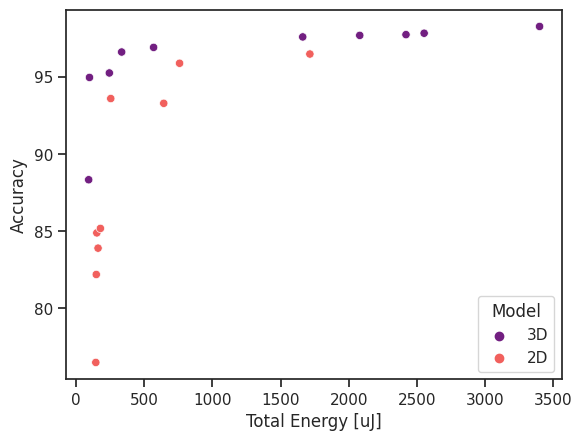

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figsize=(15, 10)

# Add a new column to each DataFrame to identify their source
three_df['Model'] = '3D'
two_df['Model'] = '2D'

# Concatenate the DataFrames
combined_df = pd.concat([three_df, two_df], ignore_index=True)

sns.set_style("ticks")
scatterplot = sns.scatterplot(data=combined_df, x='Total Energy [uJ]', y='Accuracy', hue='Model', palette='magma')
scatterplot.set_xlabel('Total Energy [uJ]')
scatterplot.set_ylabel('Accuracy')

plt.show()

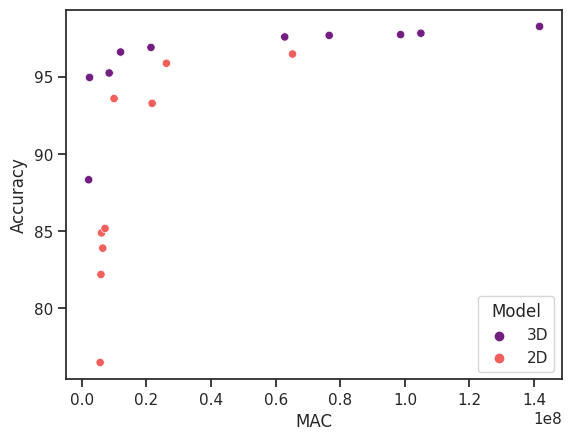

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figsize=(15, 10)

# Add a new column to each DataFrame to identify their source
three_df['Model'] = '3D'
two_df['Model'] = '2D'

# Concatenate the DataFrames
combined_df = pd.concat([three_df, two_df], ignore_index=True)

sns.set_style("ticks")
scatterplot = sns.scatterplot(data=combined_df, x='MAC', y='Accuracy', hue='Model', palette='magma')
scatterplot.set_xlabel('MAC')
scatterplot.set_ylabel('Accuracy')

plt.show()

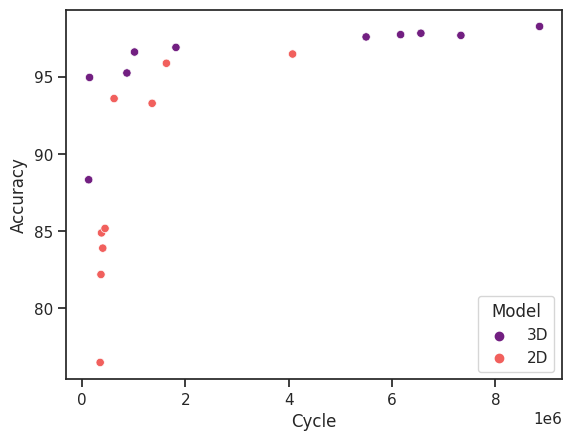

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figsize=(15, 10)

# Add a new column to each DataFrame to identify their source
three_df['Model'] = '3D'
two_df['Model'] = '2D'

# Concatenate the DataFrames
combined_df = pd.concat([three_df, two_df], ignore_index=True)

sns.set_style("ticks")
scatterplot = sns.scatterplot(data=combined_df, x='Cycle', y='Accuracy', hue='Model', palette='magma')
scatterplot.set_xlabel('Cycle')
scatterplot.set_ylabel('Accuracy')

plt.show()

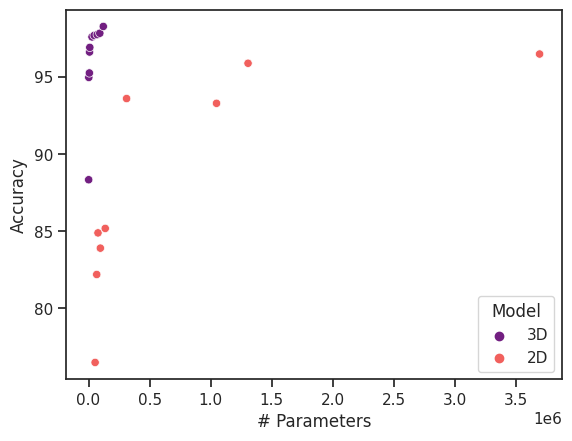

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figsize=(15, 10)

# Add a new column to each DataFrame to identify their source
three_df['Model'] = '3D'
two_df['Model'] = '2D'

# Concatenate the DataFrames
combined_df = pd.concat([three_df, two_df], ignore_index=True)

sns.set_style("ticks")
scatterplot = sns.scatterplot(data=combined_df, x='Param', y='Accuracy', hue='Model', palette='magma')
scatterplot.set_xlabel('# Parameters')
scatterplot.set_ylabel('Accuracy')

plt.show()